## 10. 3.6 슈뢰딩거 포아송 방정식

### Poisson equation in 2D


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
import scipy.linalg as slin
import scipy.integrate as inte
import fractions
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


nx = 121
ny = 29

#coefficients
Nc = 2.86*1e+25
kT = sc.k*300
ni = Nc*np.exp(-0.56*sc.e/kT)
Nacc = 1e+26
q = sc.e 
e1 = 3.9*sc.epsilon_0
e2 = 11.7*sc.epsilon_0

dx = 30*1e-9/(nx-1)


GV = 0.0

phi = np.full(nx*ny,0.33374)
dphi_bc = np.zeros((nx*ny,nx*ny))

#setting phi_bc and corresponding H
H = np.zeros((nx*ny,nx*ny))

interx1 = int(nx/3)
interx2 = int(2*nx/3)
intery1 = int(ny/7)
intery2 = int(6*ny/7)

phi_bc = np.zeros(nx*ny)
phi_bc[interx1:interx2+1] = 0.33374 + GV
phi_bc[nx*(ny-1)+interx1:nx*(ny-1)+interx2+1] = 0.33374+GV

np.fill_diagonal(H[0:nx*(ny-1)+interx2+1],1)
np.fill_diagonal(H[0:nx*(ny-1)+interx1],0)
np.fill_diagonal(H[0:interx2+1],1)
np.fill_diagonal(H[0:interx1],0)

for i in range(intery2-intery1-1) :
	phi_bc[nx*int(intery1+1 + i)] = np.arcsinh(Nacc/(2*ni))*kT/q
	phi_bc[nx*int(intery1+1 + i + 1) -1] = np.arcsinh(Nacc/(2*ni))*kT/q
	H[nx*int(intery1+1+i),nx*int(intery1+1+i)] = 1
	H[nx*int(intery1+1+i+1)-1,nx*int(intery1+1+i+1)-1] = 1


#Neumann Boundary Conditions
#All corners
H[0,0] = -e1; H[0,1] = 0.5*e1 ; H[0,nx] = 0.5*e1;
H[nx-1,nx-1] = -e1; H[nx-1,nx-2] =0.5*e1; H[nx-1,2*nx-1] = 0.5*e1;
H[nx*(ny-1),nx*(ny-1)] = -e1; H[nx*(ny-1),nx*(ny-1)+1] = 0.5*e1; H[nx*(ny-1),nx*(ny-2)] = 0.5*e1;
H[nx*ny-1,nx*ny-1] = -e1; H[nx*ny-1,nx*ny-2] = 0.5*e1; H[nx*ny-1,nx*(ny-1)-1] = 0.5*e1;

#Upper&below boundary
for i in range(interx1-1):
	H[1+i,1+i] = -2*e1; H[1+i,1+i-1] = 0.5*e1; H[1+i,1+i+1] = 0.5*e1; H[1+i,1+i+nx] = e1;
	ru = interx2 + i +1
	H[ru,ru] = -2*e1; H[ru,ru-1] = 0.5*e1; H[ru,ru+1] = 0.5*e1; H[ru,ru+nx] = e1;
	leftb = nx*(ny-1)+1+i
	H[leftb,leftb] = -2*e1; H[leftb,leftb+1] = 0.5*e1; H[leftb,leftb-1]=0.5*e1; H[leftb,leftb-nx] = e1;
	rightb = nx*(ny-1)+1+i+interx2
	H[rightb,rightb] = -2*e1; H[rightb,rightb+1] = 0.5*e1; H[rightb,rightb-1]=0.5*e1; H[rightb,rightb-nx] = e1;

#left&right boundary
for i in range(intery1-1):
	lu = (i+1)*nx
	H[lu,lu] = -2*e1; H[lu,lu-nx] = 0.5*e1; H[lu,lu+nx] = 0.5*e1; H[lu,lu+1] = e1;
	rightu = (i+2)*nx-1
	H[rightu,rightu] = -2*e1; H[rightu,rightu-nx] = 0.5*e1; H[rightu,rightu+nx] = 0.5*e1; H[rightu,rightu-1] = e1;
	ld = nx*(i+intery2+1)
	rd = nx*(i+intery2+2)-1
	H[ld,ld] = -2*e1;H[ld,ld-nx] = 0.5*e1;H[ld,ld+nx]=0.5*e1; H[ld,ld+1]=e1;
	H[rd,rd] = -2*e1;H[rd,rd-nx] = 0.5*e1;H[rd,rd+nx]=0.5*e1; H[rd,rd+1]=e1;
	
#interfaces
lu = nx*intery1; ru = nx*intery1+nx-1;
ld = nx*intery2; rd = nx*intery2+nx-1;

H[lu,lu] = -(e1+e2); H[lu,lu-nx] = 0.5*e1; H[lu,lu+nx] = 0.5*e2; H[lu,lu+1] = (e1+e2)/2;
H[ru,ru] = -(e1+e2); H[ru,ru-nx] = 0.5*e1; H[ru,ru+nx] = 0.5*e2; H[ru,ru-1] = (e1+e2)/2;
H[ld,ld]= -(e1+e2);H[ld,ld-nx] = 0.5*e2;H[ld,ld+nx]=0.5*e1; H[ld,ld+1]=(e1+e2)/2;
H[rd,rd]= -(e1+e2);H[rd,rd-nx] = 0.5*e2;H[rd,rd+nx]=0.5*e1; H[rd,rd+1]=(e1+e2)/2;

#middle part
for j in range(ny-2):
	for i in range(nx-2):
		centeru = nx*(j+1)+i+1
		if(j+1<intery1) : H[centeru,centeru] = -4*e1; H[centeru,centeru-1] = e1; H[centeru,centeru+1] = e1; H[centeru,centeru+nx]=e1;H[centeru,centeru-nx] = e1;
		elif(j+1==intery1) : H[centeru,centeru] = -2*(e1+e2); H[centeru,centeru-1] = (e1+e2)/2; H[centeru,centeru+1] = (e1+e2)/2; H[centeru,centeru+nx]=e2;H[centeru,centeru-nx] = e1;
		elif((j+1>intery1)&(j+1<intery2)) : 
			H[centeru,centeru] = -4*e2; H[centeru,centeru-1] = e2; H[centeru,centeru+1] = e2; H[centeru,centeru+nx]=e2; H[centeru,centeru-nx] = e2;
			if((i+1>=interx1)&(i+1<=interx2)):
				phi_bc[centeru] = dx*dx*q*2*ni*np.sinh(q*phi[centeru]/kT)
				dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
			else : 
				phi_bc[centeru] = dx*dx*q*(Nacc+2*ni*np.sinh(q*phi[centeru]/kT))
				dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
		elif(j+1==intery2) : H[centeru,centeru] = -2*(e1+e2); H[centeru,centeru-1] = (e1+e2)/2; H[centeru,centeru+1] = (e1+e2)/2; H[centeru,centeru+nx]=e1;H[centeru,centeru-nx] = e2;
		else : H[centeru,centeru] = -4*e1; H[centeru,centeru-1] = e1; H[centeru,centeru+1] = e1; H[centeru,centeru+nx]=e1;H[centeru,centeru-nx] = e1;
			
print("for all done")

for i in range(nx*ny):
	tmp = 0
	for j in range(ny*nx):
		if(H[i,j]!=0) : tmp=tmp+1
	if(tmp==0): 
		yline = int(i/nx)
		xline = int(i%nx)
		print("(",yline,xline,")")


tmp = 200
min_phi = 100 
itr = 0

#centerphi = []
centerphi = np.zeros(39)

while abs(tmp-min_phi)>1e-5 :
	print("itr : ",itr+1,"abs(diff) : ",tmp-min_phi)
	min_phi = np.min(phi)
	residue = np.matmul(H,phi) - phi_bc
	Jaco = H -dphi_bc
	phi = phi - slin.solve(Jaco,residue)
	tmp = np.min(phi)
	centerphi[itr] = abs(tmp-min_phi)
	for j in range(ny-2):
		for i in range(nx-2):
			centeru = nx*(j+1)+i+1
			if((j+1>intery1)&(j+1<intery2)) : 
				if((i+1>=interx1)&(i+1<=interx2)):
					phi_bc[centeru] = dx*dx*q*2*ni*np.sinh(q*phi[centeru]/kT)
					dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
				else : 
					phi_bc[centeru] = dx*dx*q*(Nacc+2*ni*np.sinh(q*phi[centeru]/kT))
					dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
	itr = itr+1			

#centerphi = np.array(centerphi)

plt.plot(range(itr), centerphi[1:],label=r'$V_{gate}=1.1$',c='r',marker='o',lw=0,ms=10,mfc='none')
#plt.plot(range(1,itr+1), centerphi,label=r'$V_{gate}=1.1$',c='r',marker='o',lw=0,ms=10,mfc='none')
plt.xlabel("Iterations",fontsize = 18)
plt.ylabel(r'$|\phi^{(n+1)}_{min}-\phi^{(n)}_{min}|$',fontsize = 18)
plt.legend(fontsize=18)
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

	
Z = np.reshape(phi,(-1,nx))
x = np.linspace(0,30e-9,nx,endpoint=True)
y = np.linspace(0,7e-9,ny,endpoint=True)
X,Y = np.meshgrid(x,y)

#Z = np.log(Z)

norm = plt.Normalize(Z.min(), Z.max())
colors = cm.viridis(norm(Z))
rcount, ccount, _ = colors.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # 더 권장되는 방식

# z축 라벨 회전 방지 (필요 시만 사용, 오류 시 제거)
# ax.zaxis.set_rotate_label(False)

# 축 라벨 설정
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_zlabel(r"$\phi(x,y)$", fontsize=12)

# 눈금 폰트 크기 설정
ax.tick_params(labelsize=12)

# 서피스 플롯
surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)

# 배경을 투명하게 설정
surf.set_facecolor((0, 0, 0, 0))

# 플롯 표시
plt.show()

# 전자 밀도 계산 (2D 배열)
e_density_2D = ni * np.exp(q * Z / kT)

# x 방향으로 전자 밀도 평균 (혹은 특정 y값에서의 전자 밀도 추출)
# 여기서는 중앙 y 방향에서 전자 밀도 추출 예시:
middle_y_index = ny // 2
e_density = e_density_2D[middle_y_index, :]

plt.plot(x, e_density, label=r'$V_{gate}=1.1V$', c='r', marker='o', lw=0, ms=10, mfc='none')
plt.xlabel("x", fontsize=18)
plt.ylabel(r"$n(x)$", fontsize=18)
plt.legend(fontsize=18)
plt.yscale('log')  # 전자 밀도는 log scale이 더 좋습니다
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()



for all done
itr :  1 abs(diff) :  100
itr :  2 abs(diff) :  -2.304964482426295


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=1.60026e-25): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  3 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=4.3148e-25): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  4 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=1.16139e-24): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  5 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=3.12934e-24): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  6 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=8.44798e-24): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  7 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=2.28192e-23): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  8 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=6.15769e-23): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  9 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=1.65967e-22): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  10 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=4.47359e-22): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  11 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=1.20671e-21): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  12 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=3.2556e-21): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  13 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=8.7797e-21): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  14 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=2.367e-20): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  15 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=6.38314e-20): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  16 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=1.7218e-19): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  17 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=4.64276e-19): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  18 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=1.25138e-18): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  19 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=3.37348e-18): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  20 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=9.09867e-18): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  21 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=2.45393e-17): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  22 abs(diff) :  0.025851999786435487


C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:133: LinAlgWarning: Ill-conditioned matrix (rcond=6.61454e-17): result may not be accurate.
  phi = phi - slin.solve(Jaco,residue)


itr :  23 abs(diff) :  0.025851999786435487
itr :  24 abs(diff) :  0.025851999786435487
itr :  25 abs(diff) :  0.025851999786435487
itr :  26 abs(diff) :  0.025851999786435487
itr :  27 abs(diff) :  0.025851999786435487
itr :  28 abs(diff) :  0.025851999786435487
itr :  29 abs(diff) :  0.025851999786435487
itr :  30 abs(diff) :  0.025851999786435265
itr :  31 abs(diff) :  0.0258519997864346
itr :  32 abs(diff) :  0.025851999786432822
itr :  33 abs(diff) :  0.025851999786427937
itr :  34 abs(diff) :  0.02585199978641506
itr :  35 abs(diff) :  0.025851999786379753
itr :  36 abs(diff) :  0.02585199978628383
itr :  37 abs(diff) :  0.02585199978602315
itr :  38 abs(diff) :  0.025851999785314606
itr :  39 abs(diff) :  0.025851999783388813
itr :  40 abs(diff) :  0.025851999778153556
itr :  41 abs(diff) :  0.02585199976392283
itr :  42 abs(diff) :  0.02585199972523966
itr :  43 abs(diff) :  0.02585199962008755
itr :  44 abs(diff) :  0.02585199933425264
itr :  45 abs(diff) :  0.0258519985572593

C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:152: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18)


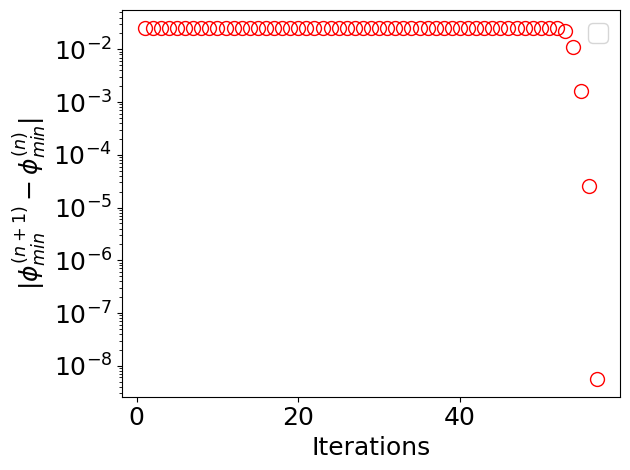

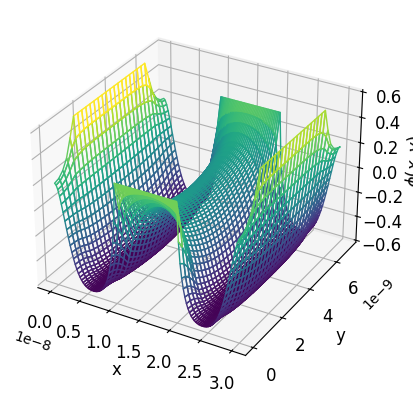

C:\Users\ppjm7\AppData\Local\Temp\ipykernel_12348\4004136048.py:206: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18)


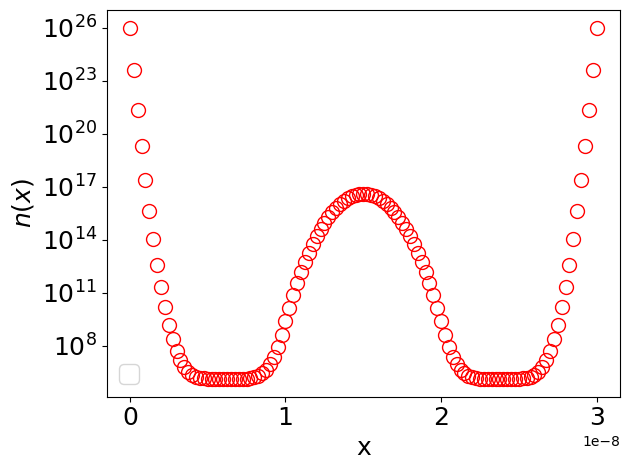

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sc
import scipy.linalg as slin
import scipy.integrate as inte
import fractions
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


nx = 121
ny = 29

#coefficients
Nc = 2.86*1e+25
kT = sc.k*300
ni = Nc*np.exp(-0.56*sc.e/kT)
Nacc = 1e+26
q = sc.e 
e1 = 3.9*sc.epsilon_0
e2 = 11.7*sc.epsilon_0

dx = 30*1e-9/(nx-1)


#GV = 1.1
GV = 0
phi = np.full(nx*ny,0.33374)
dphi_bc = np.zeros((nx*ny,nx*ny))

#setting phi_bc and corresponding H
H = np.zeros((nx*ny,nx*ny))

interx1 = int(nx/3)
interx2 = int(2*nx/3)
intery1 = int(ny/7)
intery2 = int(6*ny/7)

phi_bc = np.zeros(nx*ny)
phi_bc[interx1:interx2+1] = 0.33374 + GV
phi_bc[nx*(ny-1)+interx1:nx*(ny-1)+interx2+1] = 0.33374+GV

np.fill_diagonal(H[0:nx*(ny-1)+interx2+1],1)
np.fill_diagonal(H[0:nx*(ny-1)+interx1],0)
np.fill_diagonal(H[0:interx2+1],1)
np.fill_diagonal(H[0:interx1],0)

for i in range(intery2-intery1-1) :
	phi_bc[nx*int(intery1+1 + i)] = np.arcsinh(Nacc/(2*ni))*kT/q
	phi_bc[nx*int(intery1+1 + i + 1) -1] = np.arcsinh(Nacc/(2*ni))*kT/q
	H[nx*int(intery1+1+i),nx*int(intery1+1+i)] = 1
	H[nx*int(intery1+1+i+1)-1,nx*int(intery1+1+i+1)-1] = 1


#Neumann Boundary Conditions
#All corners
H[0,0] = -e1; H[0,1] = 0.5*e1 ; H[0,nx] = 0.5*e1;
H[nx-1,nx-1] = -e1; H[nx-1,nx-2] =0.5*e1; H[nx-1,2*nx-1] = 0.5*e1;
H[nx*(ny-1),nx*(ny-1)] = -e1; H[nx*(ny-1),nx*(ny-1)+1] = 0.5*e1; H[nx*(ny-1),nx*(ny-2)] = 0.5*e1;
H[nx*ny-1,nx*ny-1] = -e1; H[nx*ny-1,nx*ny-2] = 0.5*e1; H[nx*ny-1,nx*(ny-1)-1] = 0.5*e1;

#Upper&below boundary
for i in range(interx1-1):
	H[1+i,1+i] = -2*e1; H[1+i,1+i-1] = 0.5*e1; H[1+i,1+i+1] = 0.5*e1; H[1+i,1+i+nx] = e1;
	ru = interx2 + i +1
	H[ru,ru] = -2*e1; H[ru,ru-1] = 0.5*e1; H[ru,ru+1] = 0.5*e1; H[ru,ru+nx] = e1;
	leftb = nx*(ny-1)+1+i
	H[leftb,leftb] = -2*e1; H[leftb,leftb+1] = 0.5*e1; H[leftb,leftb-1]=0.5*e1; H[leftb,leftb-nx] = e1;
	rightb = nx*(ny-1)+1+i+interx2
	H[rightb,rightb] = -2*e1; H[rightb,rightb+1] = 0.5*e1; H[rightb,rightb-1]=0.5*e1; H[rightb,rightb-nx] = e1;

#left&right boundary
for i in range(intery1-1):
	lu = (i+1)*nx
	H[lu,lu] = -2*e1; H[lu,lu-nx] = 0.5*e1; H[lu,lu+nx] = 0.5*e1; H[lu,lu+1] = e1;
	rightu = (i+2)*nx-1
	H[rightu,rightu] = -2*e1; H[rightu,rightu-nx] = 0.5*e1; H[rightu,rightu+nx] = 0.5*e1; H[rightu,rightu-1] = e1;
	ld = nx*(i+intery2+1)
	rd = nx*(i+intery2+2)-1
	H[ld,ld] = -2*e1;H[ld,ld-nx] = 0.5*e1;H[ld,ld+nx]=0.5*e1; H[ld,ld+1]=e1;
	H[rd,rd] = -2*e1;H[rd,rd-nx] = 0.5*e1;H[rd,rd+nx]=0.5*e1; H[rd,rd+1]=e1;
	
#interfaces
lu = nx*intery1; ru = nx*intery1+nx-1;
ld = nx*intery2; rd = nx*intery2+nx-1;

H[lu,lu] = -(e1+e2); H[lu,lu-nx] = 0.5*e1; H[lu,lu+nx] = 0.5*e2; H[lu,lu+1] = (e1+e2)/2;
H[ru,ru] = -(e1+e2); H[ru,ru-nx] = 0.5*e1; H[ru,ru+nx] = 0.5*e2; H[ru,ru-1] = (e1+e2)/2;
H[ld,ld]= -(e1+e2);H[ld,ld-nx] = 0.5*e2;H[ld,ld+nx]=0.5*e1; H[ld,ld+1]=(e1+e2)/2;
H[rd,rd]= -(e1+e2);H[rd,rd-nx] = 0.5*e2;H[rd,rd+nx]=0.5*e1; H[rd,rd+1]=(e1+e2)/2;

#middle part
for j in range(ny-2):
	for i in range(nx-2):
		centeru = nx*(j+1)+i+1
		if(j+1<intery1) : H[centeru,centeru] = -4*e1; H[centeru,centeru-1] = e1; H[centeru,centeru+1] = e1; H[centeru,centeru+nx]=e1;H[centeru,centeru-nx] = e1;
		elif(j+1==intery1) : H[centeru,centeru] = -2*(e1+e2); H[centeru,centeru-1] = (e1+e2)/2; H[centeru,centeru+1] = (e1+e2)/2; H[centeru,centeru+nx]=e2;H[centeru,centeru-nx] = e1;
		elif((j+1>intery1)&(j+1<intery2)) : 
			H[centeru,centeru] = -4*e2; H[centeru,centeru-1] = e2; H[centeru,centeru+1] = e2; H[centeru,centeru+nx]=e2; H[centeru,centeru-nx] = e2;
			if((i+1>=interx1)&(i+1<=interx2)):
				phi_bc[centeru] = dx*dx*q*2*ni*np.sinh(q*phi[centeru]/kT)
				dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
			else : 
				phi_bc[centeru] = dx*dx*q*(Nacc+2*ni*np.sinh(q*phi[centeru]/kT))
				dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
		elif(j+1==intery2) : H[centeru,centeru] = -2*(e1+e2); H[centeru,centeru-1] = (e1+e2)/2; H[centeru,centeru+1] = (e1+e2)/2; H[centeru,centeru+nx]=e1;H[centeru,centeru-nx] = e2;
		else : H[centeru,centeru] = -4*e1; H[centeru,centeru-1] = e1; H[centeru,centeru+1] = e1; H[centeru,centeru+nx]=e1;H[centeru,centeru-nx] = e1;
			
print("for all done")

for i in range(nx*ny):
	tmp = 0
	for j in range(ny*nx):
		if(H[i,j]!=0) : tmp=tmp+1
	if(tmp==0): 
		yline = int(i/nx)
		xline = int(i%nx)
		print("(",yline,xline,")")


tmp = 200
min_phi = 100 
itr = 0

#centerphi = np.zeros(39)
centerphi = np.zeros(100)

while abs(tmp-min_phi)>1e-5 :
	print("itr : ",itr+1,"abs(diff) : ",tmp-min_phi)
	min_phi = np.min(phi)
	residue = np.matmul(H,phi) - phi_bc
	Jaco = H -dphi_bc
	phi = phi - slin.solve(Jaco,residue)
	tmp = np.min(phi)
	centerphi[itr] = abs(tmp-min_phi)
	for j in range(ny-2):
		for i in range(nx-2):
			centeru = nx*(j+1)+i+1
			if((j+1>intery1)&(j+1<intery2)) : 
				if((i+1>=interx1)&(i+1<=interx2)):
					phi_bc[centeru] = dx*dx*q*2*ni*np.sinh(q*phi[centeru]/kT)
					dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
				else : 
					phi_bc[centeru] = dx*dx*q*(Nacc+2*ni*np.sinh(q*phi[centeru]/kT))
					dphi_bc[centeru,centeru] = dx*dx*q*2*ni*np.cosh(q*phi[centeru]/kT)*q/kT
	itr = itr+1			

#plt.plot(range(itr), centerphi[1:],c='r',marker='o',lw=0,ms=10,mfc='none')
plt.plot(range(1, itr), centerphi[1:itr], c='r', marker='o', lw=0, ms=10, mfc='none')
plt.xlabel("Iterations",fontsize = 18)
plt.ylabel(r'$|\phi^{(n+1)}_{min}-\phi^{(n)}_{min}|$',fontsize = 18)
plt.legend(fontsize=18)
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

	
Z = np.reshape(phi,(-1,nx))
x = np.linspace(0,30e-9,nx,endpoint=True)
y = np.linspace(0,7e-9,ny,endpoint=True)
X,Y = np.meshgrid(x,y)

#Z = np.log(Z)

norm = plt.Normalize(Z.min(), Z.max())
colors = cm.viridis(norm(Z))
rcount, ccount, _ = colors.shape

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # 더 권장되는 방식

# z축 라벨 회전 방지 (필요 시만 사용, 오류 시 제거)
# ax.zaxis.set_rotate_label(False)

# 축 라벨 설정
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_zlabel(r"$\phi(x,y)$", fontsize=12)

# 눈금 폰트 크기 설정
ax.tick_params(labelsize=12)

# 서피스 플롯
surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)

# 배경을 투명하게 설정
surf.set_facecolor((0, 0, 0, 0))

# 플롯 표시
plt.show()

# 전자 밀도 계산 (2D 배열)
e_density_2D = ni * np.exp(q * Z / kT)

# x 방향으로 전자 밀도 평균 (혹은 특정 y값에서의 전자 밀도 추출)
# 여기서는 중앙 y 방향에서 전자 밀도 추출 예시:
middle_y_index = ny // 2
e_density = e_density_2D[middle_y_index, :]


plt.plot(x, e_density, c='r', marker='o', lw=0, ms=10, mfc='none')
plt.xlabel("x", fontsize=18)
plt.ylabel(r"$n(x)$", fontsize=18)
plt.legend(fontsize=18)
plt.yscale('log')  # 전자 밀도는 log scale이 더 좋습니다
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()


Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.
Singular matrix, stopping iteration.


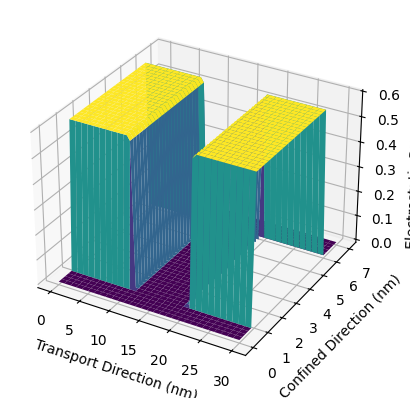

In [11]:
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import spsolve

# Constants
q = 1.602192e-19  # Elementary charge, C
e_si = 11.7
e_ox = 3.9
e_mean = (e_si + e_ox) / 2
e0 = 8.854e-12  # Vacuum permittivity, F/m
k_B = 1.380662e-23
T = 300  # Temperature, K
nint = 1.075e+16  # Intrinsic carrier density, /m^3

# Device parameters
GLg = 10e-9  # Gate length, m
CLg = GLg
DLg = 10e-9  # Drain length, m
SLg = DLg  # Source length, m
FLg = CLg + DLg + SLg  # Channel length, m
tox = 1e-9  # Oxide thickness, m
bulk = 5e-9  # Silicon thickness, m

# Mesh parameters
Nxx = 61
Nzz = 36
dx = FLg / (Nxx - 1)
dy = (bulk + 2 * tox) / (Nzz - 1)

# Doping
Nbody = 0  # Body doping
Nd = np.float64(1e+26)  # Explicitly define Nd as a float


# Index for source and drain in x-direction (zero-based)
Source = int(SLg / dx)
Drain = int((SLg + CLg) / dx)

# Doping profile (2D array)
Ndop = np.full((Nzz, Nxx), Nbody, dtype=np.float64)
Ndop[:, :Source] = Nd  # Source doping
Ndop[:, Drain + 1 :] = Nd  # Drain doping
Ndop[:, Source] = (Nd + Nbody) / 2  # Source-channel interface
Ndop[:, Drain] = (Nd + Nbody) / 2  # Channel-drain interface

# Thermal voltage
thermal = k_B * T / q

# Interfaces in y-direction (zero-based)
interface1 = int(round(tox / dy))
interface2 = int(round((tox + bulk) / dy))

# Prepare sparse matrix A and residual vector
size = Nxx * Nzz
A = lil_matrix((size, size))
res = np.zeros((size, 1))

# Initial potential guess
phi = np.zeros((Nzz, Nxx))
phi[interface1:interface2, :Source] = thermal * np.arcsinh(Nd / (2 * nint))
phi[interface1:interface2, Drain + 1 :] = thermal * np.arcsinh(Nd / (2 * nint))
phi[interface1:interface2, Source] = thermal * np.arcsinh(Nd / (4 * nint))
phi[interface1:interface2, Drain] = th.ermal * np.arcsinh(Nd / (4 * nint))

phi = phi.T.reshape((size, 1))  # Flatten in column-major order

# Gate indices in flattened array
Gi1 = int((Nxx // 2) - GLg / dx / 2)
Gi2 = int((Nxx // 2) + GLg / dx / 2)

# Save potentials for different gate voltages
save_phi = np.zeros((Nzz, Nxx, 12))

# Thermal constants for finite difference
dx2 = 1 / dx ** 2
dy2 = 1 / dy ** 2

Vbarrier = 0.33



# Main loop over gate voltages
Jaco.setdiag(Jaco.diagonal() + 1e-15)
for iVg in range(12):
    Vg = iVg / 10
    for Newton1 in range(500):
        Jaco = A.copy()
        for iy in range(Nzz):
            for ix in range(Nxx):
                index = ix + iy * Nxx  # Flattened index

                # Boundary conditions example (top oxide layer)
                
                if iy == 0:
                    if Gi1 <= ix <= Gi2:
                        Jaco[index, index] = 1
                        res[index, 0] = phi[index, 0] - Vbarrier - Vg
                    else:
                        # Neumann boundary conditions or others can be implemented here
                        pass
                # Other mesh points to be handled here as needed...

        # Newton update (simple example, not full here)
        # Invert matrix and update phi:
        try:
            update_phi = np.linalg.solve(Jaco.toarray(), -res)
            #update_phi = spsolve(Jaco.tocsr(), -res)
        except np.linalg.LinAlgError:
            print("Singular matrix, stopping iteration.")
            break

        phi += update_phi.reshape((size, 1))
        error_value = np.max(np.abs(update_phi))

        if error_value < 1e-15:
            break

    save_phi[:, :, iVg] = phi.reshape((Nxx, Nzz)).T

# Final phi reshape
phi = phi.reshape((Nxx, Nzz)).T

# Plot
x = np.linspace(0, FLg * 1e9, Nxx)  # Convert to nm
y = np.linspace(0, (bulk + 2 * tox) * 1e9, Nzz)

X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, phi, cmap='viridis')
ax.set_xlabel('Transport Direction (nm)')
ax.set_ylabel('Confined Direction (nm)')
ax.set_zlabel('Electrostatic Potential (V)')
plt.show()
